In [8]:
!ls '../input'

respiratory-sound-database  specimages


In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics

from sklearn.utils import class_weight
from collections import Counter

import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

import pandas as pd

In [10]:
train_loc = '../input/specimages/train_test_split/train/'
test_loc = '../input/specimages/train_test_split/val/'

In [11]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory=train_loc, target_size=(180,180))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory=test_loc, target_size=(180,180))

Found 5515 images belonging to 8 classes.
Found 1383 images belonging to 8 classes.


In [12]:
diagnosis_csv = '../input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv'
diagnosis = pd.read_csv(diagnosis_csv, names=['pId', 'diagnosis'])
diagnosis.head()

,pId,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [13]:
categories = diagnosis['diagnosis'].unique()
categories

array(['URTI', 'Healthy', 'Asthma', 'COPD', 'LRTI', 'Bronchiectasis',
       'Pneumonia', 'Bronchiolitis'], dtype=object)

In [14]:
rn = ResNet50(weights='imagenet')
rn.summary()

x  = rn.output

102973440/102967424 [==============================] - 7s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [15]:
prediction = Dense(8, activation='softmax', name='predictions')(x)
model = Model(inputs=rn.input, outputs=prediction)

In [16]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-25:]:
    layer.trainable = True
    print("Layer '%s' is trainable" % layer.name)  

Layer 'conv5_block1_add' is trainable
Layer 'conv5_block1_out' is trainable
Layer 'conv5_block2_1_conv' is trainable
Layer 'conv5_block2_1_bn' is trainable
Layer 'conv5_block2_1_relu' is trainable
Layer 'conv5_block2_2_conv' is trainable
Layer 'conv5_block2_2_bn' is trainable
Layer 'conv5_block2_2_relu' is trainable
Layer 'conv5_block2_3_conv' is trainable
Layer 'conv5_block2_3_bn' is trainable
Layer 'conv5_block2_add' is trainable
Layer 'conv5_block2_out' is trainable
Layer 'conv5_block3_1_conv' is trainable
Layer 'conv5_block3_1_bn' is trainable
Layer 'conv5_block3_1_relu' is trainable
Layer 'conv5_block3_2_conv' is trainable
Layer 'conv5_block3_2_bn' is trainable
Layer 'conv5_block3_2_relu' is trainable
Layer 'conv5_block3_3_conv' is trainable
Layer 'conv5_block3_3_bn' is trainable
Layer 'conv5_block3_add' is trainable
Layer 'conv5_block3_out' is trainable
Layer 'avg_pool' is trainable
Layer 'probs' is trainable
Layer 'predictions' is trainable


In [17]:
opt = Adam(lr=0.0000001)
model.compile(optimizer=opt, loss=categorical_crossentropy, 
              metrics=['accuracy', 'mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [18]:
checkpoint = ModelCheckpoint("rn_base_res.h5", monitor='val_accuracy', verbose=2, 
                             save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=2, mode='auto')

In [19]:
counter = Counter(traindata.classes)                       
max_val = float(max(counter.values()))   
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 1149.0,
 1: 55.373493975903614,
 2: 35.90625,
 3: 1.0,
 4: 17.883268482490273,
 5: 183.84,
 6: 20.157894736842106,
 7: 23.690721649484537}

In [20]:
hist = model.fit(traindata, steps_per_epoch=traindata.samples//traindata.batch_size, validation_data=testdata, 
                 class_weight=class_weights, validation_steps=testdata.samples//testdata.batch_size, 
                 epochs=35,callbacks=[checkpoint,early])

Train for 172 steps, validate for 43 steps
Epoch 1/35
171/172 [============================>.] - ETA: 0s - loss: 13.8472 - accuracy: 0.1666 - mae: 0.2187
Epoch 00001: val_accuracy improved from -inf to 0.03997, saving model to rn_base_res.h5
172/172 [==============================] - 71s 415ms/step - loss: 13.8387 - accuracy: 0.1665 - mae: 0.2187 - val_loss: 15.7426 - val_accuracy: 0.0400 - val_mae: 0.2201
Epoch 2/35
171/172 [============================>.] - ETA: 0s - loss: 13.8191 - accuracy: 0.1679 - mae: 0.2187
Epoch 00002: val_accuracy did not improve from 0.03997
172/172 [==============================] - 59s 341ms/step - loss: 13.8336 - accuracy: 0.1682 - mae: 0.2187 - val_loss: 15.7487 - val_accuracy: 0.0320 - val_mae: 0.2201
Epoch 3/35
171/172 [============================>.] - ETA: 0s - loss: 13.8125 - accuracy: 0.1715 - mae: 0.2187
Epoch 00003: val_accuracy did not improve from 0.03997
172/172 [==============================] - 58s 340ms/step - loss: 13.8268 - accuracy: 0.17

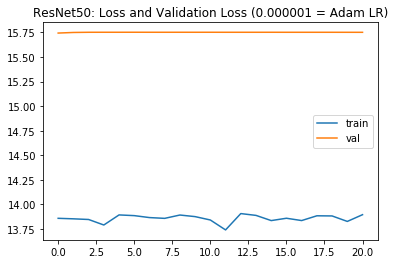

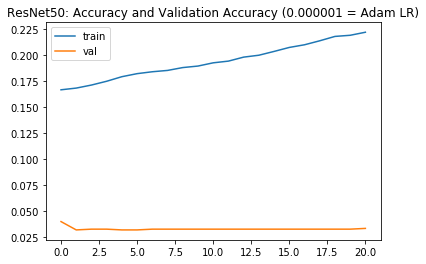

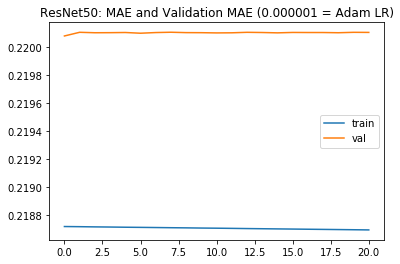

In [21]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('ResNet50: Loss and Validation Loss (0.000001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title('ResNet50: Accuracy and Validation Accuracy (0.000001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(hist.history['mae'], label='train')
plt.plot(hist.history['val_mae'], label='val')
plt.title('ResNet50: MAE and Validation MAE (0.000001 = Adam LR)')
plt.legend();
plt.show()